In [1]:
import detect
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import math

In [2]:
def remove_noise(img):
    # get binary image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to gray
    thresh = cv2.threshold(img_gray, 135, 255, cv2.THRESH_BINARY)[1] # convert to binary
    img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    # contour hierarchy
    regions, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # detect all elements
    countour_list = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        countour_list.append([x, y, w, h])
    
    # get 2nd largest contour
    countour_list = np.asarray(countour_list)  # convert to numpy-array
    column_values = ['left', 'top', 'width', 'height']
    df = pd.DataFrame(data = countour_list, columns = column_values)
    df = df.sort_values(by='width', ascending=False)

    index = df.iloc[1]
    x, y, w, h = index['left'], index['top'], index['width'], index['height']

    
    # remove outside noise
    img[:, :x] = [255, 255, 255]
    img[x + w + 1:, :] = [255, 255, 255]
    img[:y, :] = [255, 255, 255]
    img[y + h + 1:, :] = [255, 255, 255]

    return img


def img_processing(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    thresh = gray

    #  Morphological reconstruction (delete labels)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    marker = cv2.dilate(thresh, kernel, iterations = 1)
    while True:
        tmp=marker.copy()
        marker=cv2.erode(marker, kernel2)
        marker=cv2.max(thresh, marker)
        difference = cv2.subtract(tmp, marker)
        if cv2.countNonZero(difference) == 0:
            break

    # only walls
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    walls = cv2.morphologyEx(marker, cv2.MORPH_CLOSE, se)
    walls = cv2.erode(walls, kernel2, iterations = 2)

    # other objects
    other = cv2.compare(marker,walls, cv2.CMP_GE)
    other = cv2.bitwise_not(other)
    
    return thresh, marker, walls, other



def get_median(data):
    # get median of elements width & height
    column_values = ['left', 'top', 'width', 'height', 'area']
    df = pd.DataFrame(data = data, columns = column_values)
    df = df[(df['width'] >= 10) & 
            (df['height'] >= 10) & 
            (df['width'] < 50) & 
            (df['height'] < 50)].sort_values(by='width', ascending=True)
    
    m_width = df['width'].median()
    m_height = df['height'].median()
    return m_width, m_height


def find_door_list(img):
    cp_list = []
    
    thresh, marker, walls, other = img_processing(img)

    # find connected components and select by size and area
    output = cv2.connectedComponentsWithStats(other, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    m_width, m_height = get_median(stats)
    
    for i in range(num_labels):
        left, top, width, height, area = stats[i]
        if width > m_width - 10 and width < m_width + 10 and height > m_height - 10 and height < m_height + 10 and abs(width - height) < 15:
            # door gravity
            cx = round(left + width*0.5)
            cy = round(top + height*0.5) 
            cp_list.append([cx, cy])

    return cp_list


def swap(v1, v2):
    tmp = v1
    v1 = v2
    v2 = tmp
    return v1, v2


def check_wall(wall, coord):
    val = wall[coord[1], coord[0]]  # img(y, x)
    
    # 0 -> False / 255 -> True
    # return True if sum(val) else False
    return True if val else False


def check_door(other, coord):
    
    for x in range(coord[0] - 1, coord[0] + 2):
        for y in range(coord[1] - 1, coord[1] + 2):
            val = other[y, x]  # img(y, x)
            # print([x, y], val)
            
            if val: return True # 0 -> True / 255 -> False
            
    return False


def check_error_line(img, p1, p2):
    
    # wall for boundary detection / other for door detection
    _, _, walls, other = img_processing(img)
    
    
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    pt_list = []
    
    # when y = 0
    if dx == 0:
        ang = 90
        x = p1[0]
        
        # swap value when p1 > p2
        if p1[1] > p2[1]:
            p1, p2 = swap(p1, p2)
        
        # detection range of the line extended
        for y in range(p1[1] - 15, p2[1] + 15):
            pt = [x, y]
            
            # boundary detection
            if not check_wall(walls, pt):
                return False
            
            # misidentified door excluded
            if check_door(other, pt):
                # check if any similar point exists in the list
                if not pt_list or abs(sum(pt) - sum(pt_list[-1])) > 5: 
                    pt_list.append(pt)
                else: pass
                
    # when y != 0
    else:
        m = dy / dx  # get slope
        arc = math.atan(abs(m))  # get arc
        ang = (arc * 180) / math.pi  # get angle
        
        a = m
        b = p1[1] - a*p1[0]

        # x-axis
        if ang < 7:
            
            # swap value when p1 > p2
            if p1[0] > p2[0]:
                p1, p2 = swap(p1, p2)
            
            # detection range of the line extended
            for x in range(p1[0] - 15, p2[0] + 15):
                y = int(a*x + b)
                pt = [x, y]
                
                # boundary detection
                if not check_wall(walls, pt):
                    return False
                
                # misidentified door excluded
                if check_door(other, pt):
                    # check if any similar point exists in the list
                    if not pt_list or abs(sum(pt) - sum(pt_list[-1])) > 5: 
                        pt_list.append(pt)
                    else: pass
                    
                
        # y-axis
        elif ang > 83:
            
            # swap value when p1 > p2
            if p1[1] > p2[1]:
                p1, p2 = swap(p1, p2)
            
            # detection range of the line extended
            for y in range(p1[1] - 15, p2[1] + 15):
                x = int((y - b) / a)
                pt = [x, y]
                
                # boundary detection
                if not check_wall(walls, pt):
                    return False
                
                # misidentified door excluded
                if check_door(other, pt):
                    # check if any similar point exists in the list
                    if not pt_list or abs(sum(pt) - sum(pt_list[-1])) > 5: 
                        pt_list.append(pt)
                    else: pass
                
        else: return False
    print(pt_list)
    if len(pt_list) > 2: return False
    
    return True
    
    
def check_FengShui_1(img):
    cp_list = find_door_list(img)
    for i in range(len(cp_list) - 1):
        for j in range(i + 1, len(cp_list)):
            if check_error_line(img, cp_list[i], cp_list[j]):  # if true -> draw the line
                cv2.line(img, cp_list[i], cp_list[j], (0, 0, 255), 5)
                
    return img

### result testing

[[666, 315], [655, 491]]
[[581, 438], [719, 452]]


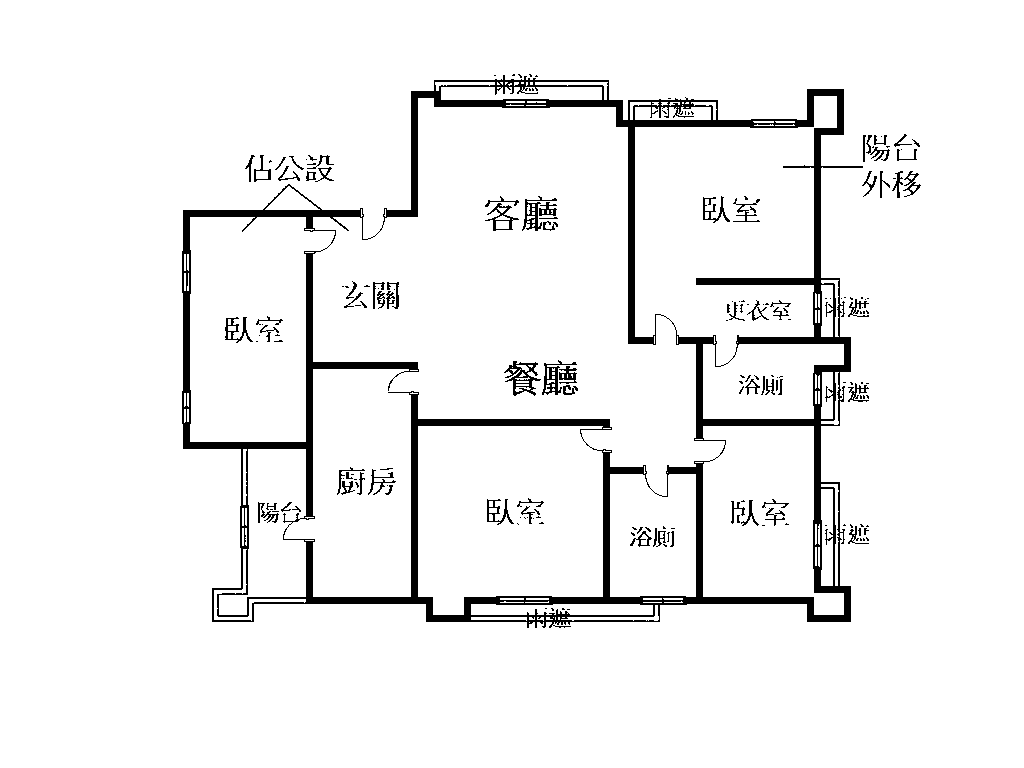

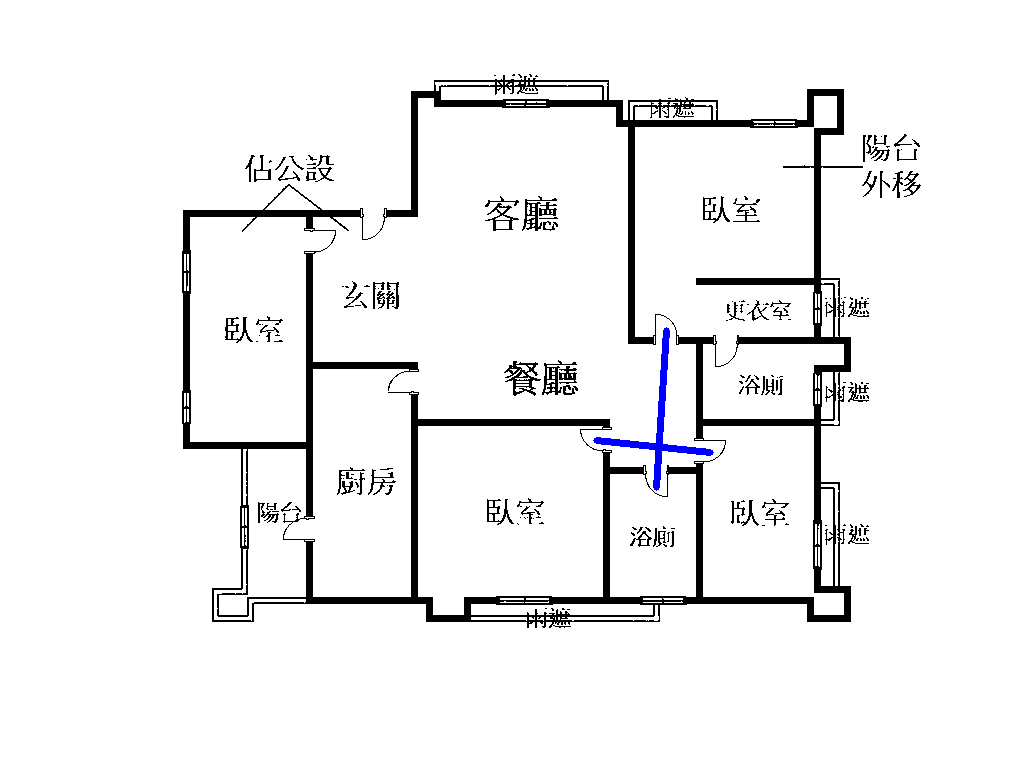

In [3]:
img = cv2.imread("images/5.jpg")
img = remove_noise(img)
res_img = img.copy()

# get doors coordinate
# c_list = find_door(img)
# check fengshui & draw the signal
res_img = check_FengShui_1(res_img)

display(Image.fromarray(img))
display(Image.fromarray(res_img))